In [74]:
import pandas as pd
import numpy as np
import requests
from zipfile import ZipFile
import io
from scipy import stats
import arviz as az
from cmdstanpy import CmdStanModel
import seaborn as sns
import matplotlib.pyplot as plt

from config import FIRSTRATE_URL

sns.set_theme()
plt.rcParams["figure.figsize"] = (15, 10)

In [2]:
def CalcReturns(prices: pd.Series) -> pd.Series:
    """
    Calculates log returns

    :param prices: series of prices
    :returns: log returns
    """
    log_returns = np.log(prices) - np.log(prices.shift(1))
    return log_returns.dropna()


def CalcNegReturns(prices: pd.Series) -> pd.Series:
    """
    Calculates log returns and sets all positive returns to 0

    :param prices: series of prices
    :returns: log returns with positive returns set to 0
    """
    log_returns = CalcReturns(prices)
    indicator = np.where(log_returns < 0, 1, 0)
    return indicator * log_returns


def CalcRV(prices: pd.Series) -> float:
    """
    Calculates daily realized variation

    pg.3:
    Barndorff-Nielsen, O. E. (2005).
    Econometrics of testing for jumps in financial economics using Bipower variation.
    Journal of Financial Econometrics, 4(1), 1–30. https://doi.org/10.1093/jjfinec/nbi022

    :param prices: series of prices from 1 trading day
    :returns: realized variation over that trading day
    """
    log_returns = CalcReturns(prices)
    return np.sum(log_returns ** 2)


def CalcBV(prices: pd.Series) -> float:
    """
    Calculates daily bipower variation.

    pg.4:
    Barndorff-Nielsen, O. E. (2005).
    Econometrics of testing for jumps in financial economics using Bipower variation.
    Journal of Financial Econometrics, 4(1), 1–30. https://doi.org/10.1093/jjfinec/nbi022

    :param prices: series of prices from 1 trading day
    :returns: bipower variation over that trading day
    """
    log_returns = CalcReturns(prices)
    return np.sum(np.abs(log_returns.shift(1)) * np.abs(log_returns))


def CalcQV(prices: pd.Series, δ: int = 390) -> float:
    """
    Calculates daily quadpower variation

    pg.9:
    Barndorff-Nielsen, O. E. (2005).
    Econometrics of testing for jumps in financial economics using Bipower variation.
    Journal of Financial Econometrics, 4(1), 1–30. https://doi.org/10.1093/jjfinec/nbi022

    :param prices: series of prices from 1 trading day
    :param δ: number of observations per day, ex δ=390 for daily minute data
    :returns: quadpower variation over that trading day
    """
    log_returns = CalcReturns(prices)
    return δ * np.sum(
        np.abs(log_returns.shift(3))
        * np.abs(log_returns.shift(2))
        * np.abs(log_returns.shift(1))
        * np.abs(log_returns)
    )


def CalcJumpStat(RV: pd.Series, BV: pd.Series, QV: pd.Series, δ: int = 390) -> float:
    """
    Calculates jump statistic

    Equation 14, pg.9:
    Barndorff-Nielsen, O. E. (2005).
    Econometrics of testing for jumps in financial economics using Bipower variation.
    Journal of Financial Econometrics, 4(1), 1–30. https://doi.org/10.1093/jjfinec/nbi022

    :param RV: series of daily realized variations
    :param BV: series of daily bipower variation
    :param QV: series of daily quadpower variation
    :param δ: number of observations per day, ex δ=390 for daily minute data
    :returns: quadpower variation over that trading day
    """
    # Equation 6, pg.5
    θ = (np.square(np.pi) / 4) + np.pi - 5
    # Equation 5, pg.4
    μ = np.sqrt(2) / np.sqrt(np.pi)
    factor1 = np.sqrt(δ) / np.sqrt(θ * np.maximum(1, QV / BV ** 2))
    factor2 = (μ ** -2 * BV / RV) - 1
    return factor1 * factor2

def LogTransform(vec):
    return np.where(vec > 0, np.log(vec), 0)


In [3]:
# Download minute data for SPX and EOD for VIX
r = requests.get(FIRSTRATE_URL + "/9841", stream=True)
spx_file = ZipFile(io.BytesIO(r.raw.read()))

# Minute SPX data
SPX = pd.read_csv(
    spx_file.open("SPX_1min.txt"),
    names=["date", "open", "high", "low", "close", "volume"],
    parse_dates=["date"],
).set_index("date")

# RV, BV, QV, J column indicating presence of jumps at 99% confidence,
# mag column indicating magnitude of jumps on jump days,
# and RCV which is the continuous part of variation only,
# calcauted as RV on non-jump days and BV on jump days
vols = (
    SPX["close"]
    .groupby(lambda x: x.floor("d"))
    .agg([("RV", CalcRV), ("BV", CalcBV), ("QV", CalcQV)])
    .assign(
        J=lambda x: CalcJumpStat(x["RV"], x["BV"], x["QV"], 390) <= stats.norm.ppf(0.01)
    )
    .assign(mag=lambda x: (x["RV"] - x["BV"]) * x["J"])
    .assign(RCV=lambda x: x["RV"] * ~x["J"] + x["BV"] * x["J"])
)

# Daily negative returns only to capture leverage effect
neg_returns = CalcNegReturns(SPX["close"].groupby(lambda x: x.date).last())


In [4]:
features = (
    pd.DataFrame(vols["RCV"])
    .assign(RCV5=lambda x: x["RCV"].rolling(5).mean())
    .assign(RCV21=lambda x: x["RCV"].rolling(21).mean())
    .assign(mag=vols["mag"])
    .assign(mag5=lambda x: x["mag"].rolling(5).mean())
    .assign(mag21=lambda x: x["mag"].rolling(21).mean())
    .assign(negret=neg_returns)
    .assign(negret5=lambda x: x["negret"].rolling(5).mean())
    .assign(negret21=lambda x: x["negret"].rolling(21).mean())
    .dropna()
)
# log transform
features[["RCV", "RCV5", "RCV21"]] = np.log(features[["RCV", "RCV5", "RCV21"]])
features[["mag", "mag5", "mag21"]] = LogTransform(features[["mag", "mag5", "mag21"]])

# 1-day forward variation
y = np.log(vols["RV"].shift(-1).dropna())

common_index = features.index.intersection(y.index)
split = int(0.75 * len(common_index))
x_train = features.loc[common_index[:split]]
x_test = features.loc[common_index[split:]]
y_train = y.loc[common_index[:split]]
y_test = y.loc[common_index[split:]]


In [18]:
model_spec = """
data {
    int N;  // Length of data
    int M;  // Number of features
    vector[N] y;  // Forecast objective
    matrix[N, M] x;  // Features matrix
    
    int N_hat;  // Test set length
    vector[N_hat] y_hat;  // Test set forecast objective
    matrix[N_hat, M] x_hat;  // Test set features
}
parameters {
    real mu;
    real<lower=0> rho;  // Regularization parameter for regression coeffcients
    vector[M] beta;
    real<lower=0> sigma;
}
model {
    mu ~ normal(0, 5);
    rho ~ normal(0, 1);
    beta ~ normal(0, rho);
    sigma ~ normal(0, 5);
    y ~ normal(mu + x * beta, sigma);
}
generated quantities {
    real y_tilde[N_hat];  // Test set posterior predictive
    real pit[N_hat];  // Probability integral transform
    y_tilde = normal_rng(mu + x_hat * beta, sigma);
    for (t in 1:N_hat) {
        pit[t] = normal_cdf(y_hat[t] | mu + dot_product(x_hat[t], beta), sigma);
    }
}
"""

In [19]:
with open("./stan_model/RV_model.stan", "w") as file:
    file.write(model_spec)

model = CmdStanModel(stan_file="./stan_model/RV_model.stan")
data = {
    "N": len(x_train),
    "M": len(x_train.columns),
    "y": y_train.values,
    "x": x_train.values,
    "N_hat": len(x_test),
    "y_hat": y_test.values,
    "x_hat": x_test.values
}
sample = model.sample(
    data=data, chains=4, parallel_chains=4, iter_warmup=250, iter_sampling=250
)


INFO:cmdstanpy:compiling stan file /home/eadains/VolatilityTrading/stan_model/RV_model.stan to exe file /home/eadains/VolatilityTrading/stan_model/RV_model
INFO:cmdstanpy:compiled model executable: /home/eadains/VolatilityTrading/stan_model/RV_model
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [20]:
model_data = az.from_cmdstanpy(
    posterior=sample, observed_data={"y": y.values}, posterior_predictive="y_tilde"
)

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'rho'}>,
        <AxesSubplot:title={'center':'rho'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

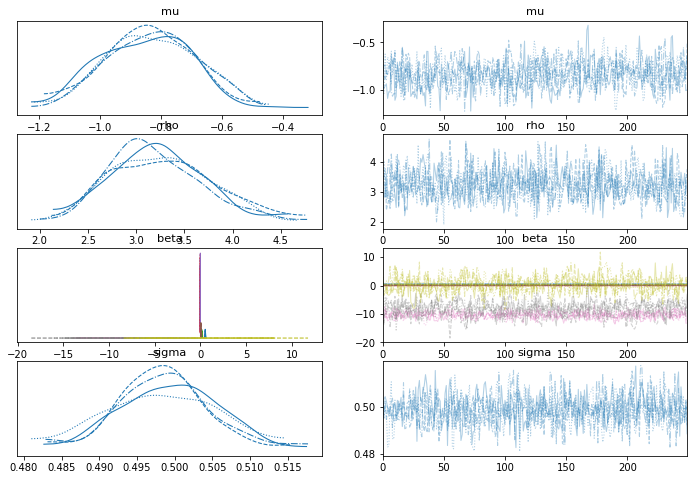

In [21]:
az.plot_trace(model_data, compact=True, var_names=["mu", "rho", "beta", "sigma"])

Text(0.5, 1.0, 'Kurtosis')

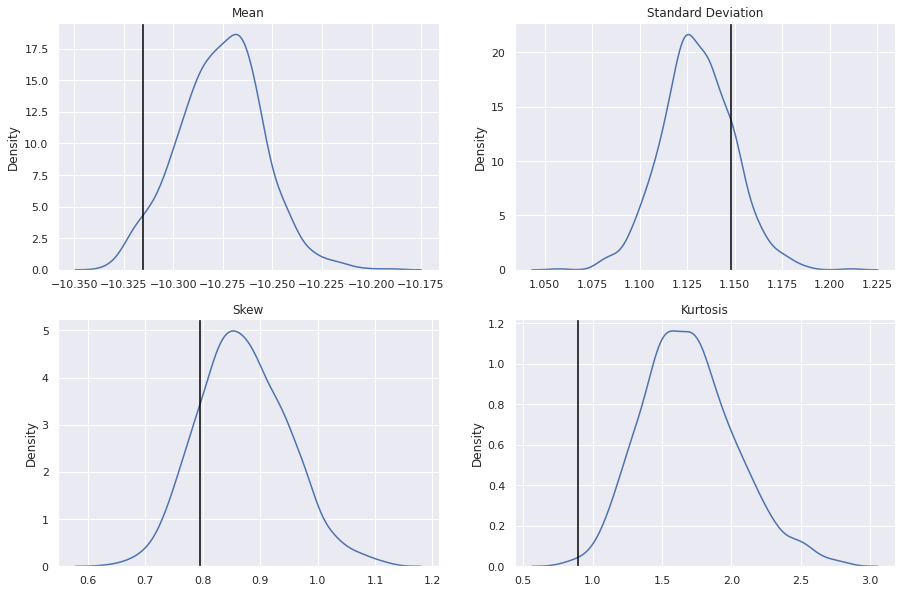

In [77]:
y_hat = model_data.posterior_predictive.y_tilde.values.reshape(1000, -1)
mean = np.mean(y_hat, axis=1)
std = np.std(y_hat, axis=1)
skew = stats.skew(y_hat, axis=1)
kurt = stats.kurtosis(y_hat, axis=1)

fig, axs = plt.subplots(2, 2)
sns.kdeplot(mean, ax=axs[0, 0])
axs[0, 0].axvline(np.mean(y_test), color="black")
axs[0, 0].set_title("Mean")
sns.kdeplot(std, ax=axs[0, 1])
axs[0, 1].axvline(np.std(y_test), color="black")
axs[0, 1].set_title("Standard Deviation")
sns.kdeplot(skew, ax=axs[1, 0])
axs[1, 0].axvline(stats.skew(y_test), color="black")
axs[1, 0].set_title("Skew")
sns.kdeplot(kurt, ax=axs[1, 1])
axs[1, 1].axvline(stats.kurtosis(y_test), color="black")
axs[1, 1].set_title("Kurtosis")

<AxesSubplot:ylabel='Density'>

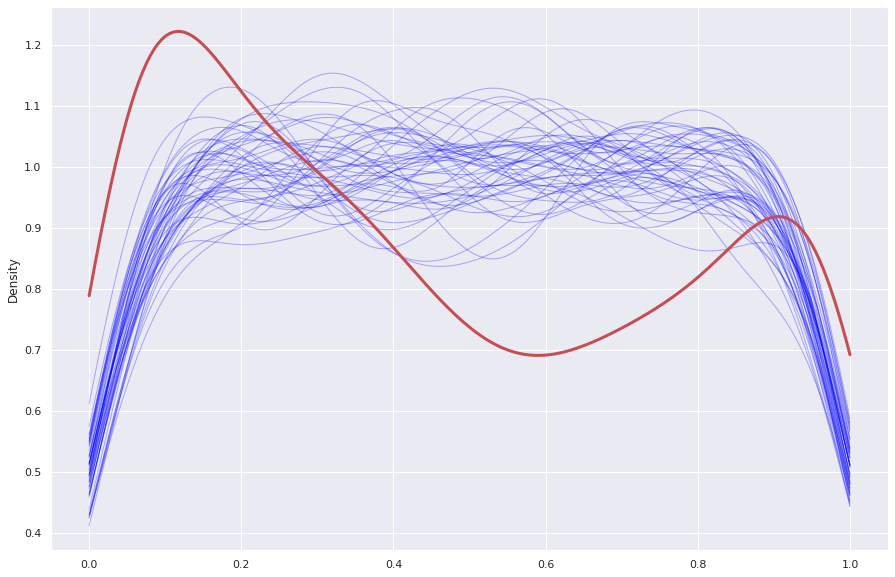

In [73]:
pit = np.mean(model_data.posterior.pit.values.reshape(1000, -1), axis=0)

for t in range(50):
    sns.kdeplot(stats.uniform(0, 1).rvs(1000), color="blue", linewidth=1, alpha=0.3, clip=(0, 1))
sns.kdeplot(pit, color="r", linewidth=3, clip=(0, 1))

In [24]:
regress = stats.linregress(np.mean(y_hat, axis=0), y_test)
print(f'Intercept: {regress.intercept} \nSlope: {regress.slope} \nR-Squared: {regress.rvalue**2}')

Intercept: -0.5205808510069172 
Slope: 0.9531276158280233 
R-Squared: 0.7085317969037079
